# Module 03: Exploratory Data Analysis - ANPC Press Releases

This notebook explores the preprocessed ANPC dataset, focusing on temporal patterns and content distributions.

In [1]:
import json
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
from wordcloud import WordCloud

# Setup paths
DATA_PATH = Path("../../02_data_preprocessing/data/processed/articles_anpc_preprocessed.json")

import sys
# Add parent directory to access 'analysis' and adjacent module to access 'preprocessing'
sys.path.append(str(Path.cwd().parent))
sys.path.append(str(Path.cwd().parent.parent / "02_data_preprocessing"))

from preprocessing.nlp_pipeline import get_romanian_stopwords
from analysis.topic_modeling import TopicModeler
from analysis.clustering import DocumentClusher

# Define domain-specific stopwords centrally
custom_stopwords = get_romanian_stopwords() + [
    "anpc", "comisar", "control", "magazine", "produs", "lei", "amendă", 
    "comercializă", "urmare", "respectare", "principal", "constatat", 
    "neconformitate", "neconformităților", "oprire", "lipsă", "sine",
    "fost", "avut", "care", "un", "una", "această", "este", "sunt",
    "prin", "pentru", "tot", "toate", "acest", "aceasta", "după", "fără",
    "și", "al", "la", "pe", "sau", "să", "din", "de", "cu", "în", "la"
]

## 1. Loading the Data

In [2]:
with open(DATA_PATH, "r", encoding="utf-8") as f:
    data = json.load(f)
df = pd.DataFrame(data)
print(f"Loaded {len(df)} articles.")
print(f"Columns: {df.columns.tolist()}")

Loaded 237 articles.
Columns: ['url', 'title', 'content', 'date', 'time', 'raw_html_path', 'scraped_at', 'title_cleaned', 'content_cleaned', 'date_iso', 'title_tokens', 'content_tokens', 'lemmatized_content']


## 2. Data Cleaning & Preparation
Converting ISO dates to datetime objects for temporal analysis.

In [3]:
df['date_dt'] = pd.to_datetime(df['date_iso'])
df['year'] = df['date_dt'].dt.year
df['month'] = df['date_dt'].dt.month
df['day_of_week'] = df['date_dt'].dt.day_name()

# Sort by date
df = df.sort_values('date_dt')

print("Dataset overview:")
display(df.head())

Dataset overview:


,url,title,content,date,time,raw_html_path,scraped_at,title_cleaned,content_cleaned,date_iso,title_tokens,content_tokens,lemmatized_content,date_dt,year,month,day_of_week
196,https://anpc.ro/companii-furnizoare-de-energie...,"Companii furnizoare de energie, amendate cu 45...",Primele rezultate ale Comandamentului pentru E...,14 ianuarie 2021,9:56 pm,/home/marius/ore/inlp/gh/inlp/01_data_collecti...,2025-12-22T16:38:35,"Companii furnizoare de energie, amendate cu 45...",Primele rezultate ale Comandamentului pentru E...,2021-01-14,"[{'text': 'Companii', 'lemma': 'companie', 'po...","[{'text': 'Primele', 'lemma': 'prim', 'pos': '...",prim rezultat al comandament pentru Energie st...,2021-01-14,2021,1,Thursday
195,https://anpc.ro/alte-195-000-lei-amenzi-aplica...,"Alte 195.000 lei amenzi, aplicate furnizorior ...",Comandamentul pentru Energie creat de Autorita...,17 ianuarie 2021,9:56 pm,/home/marius/ore/inlp/gh/inlp/01_data_collecti...,2025-12-22T16:38:24,"Alte 195.000 lei amenzi, aplicate furnizorior ...",Comandamentul pentru Energie creat de Autorita...,2021-01-17,"[{'text': 'Alte', 'lemma': 'alt', 'pos': 'DET'...","[{'text': 'Comandamentul', 'lemma': 'comandame...",comandament pentru Energie crea de autoritate ...,2021-01-17,2021,1,Sunday
194,https://anpc.ro/anpc-s-a-intalnit-cu-furnizori...,ANPC s-a întâlnit cu furnizorii de energie ele...,Autoritatea Națională pentru Protecția Consuma...,31 ianuarie 2021,9:58 pm,/home/marius/ore/inlp/gh/inlp/01_data_collecti...,2025-12-22T16:38:14,ANPC s-a întâlnit cu furnizorii de energie ele...,Autoritatea Națională pentru Protecția Consuma...,2021-01-31,"[{'text': 'ANPC', 'lemma': 'ANPC', 'pos': 'PRO...","[{'text': 'Autoritatea', 'lemma': 'autoritate'...",autoritate național pentru protecție consumato...,2021-01-31,2021,1,Sunday
193,https://anpc.ro/bilantul-comandamentelor-estiv...,Bilanțul Comandamentelor estivale 2021 ale ANPC,”Responsabiitatea a fost cuvântul care a carac...,14 septembrie 2021,9:36 pm,/home/marius/ore/inlp/gh/inlp/01_data_collecti...,2025-12-22T16:38:03,Bilanțul Comandamentelor estivale 2021 ale ANPC,”Responsabiitatea a fost cuvântul care a carac...,2021-09-14,"[{'text': 'Bilanțul', 'lemma': 'bilanț', 'pos'...","[{'text': '”', 'lemma': '”', 'pos': 'PUNCT'}, ...",responsabiitate avea fi cuvânt care avea carac...,2021-09-14,2021,9,Tuesday
192,https://anpc.ro/in-plin-sezon-al-muraturilor-a...,"În plin sezon al murăturilor, ANPC descoperă p...","Ca atare, echipele CRPC București-Ilfov au ver...",13 octombrie 2021,9:37 pm,/home/marius/ore/inlp/gh/inlp/01_data_collecti...,2025-12-22T16:37:51,"În plin sezon al murăturilor, ANPC descoperă p...","Ca atare, echipele CRPC București-Ilfov au ver...",2021-10-13,"[{'text': 'În', 'lemma': 'în', 'pos': 'ADP'}, ...","[{'text': 'Ca', 'lemma': 'ca', 'pos': 'ADV'}, ...",ca atare echipă CRPC București-Ilfov avea veri...,2021-10-13,2021,10,Wednesday


## 3. Temporal Distribution
How many press releases are published per year/month?

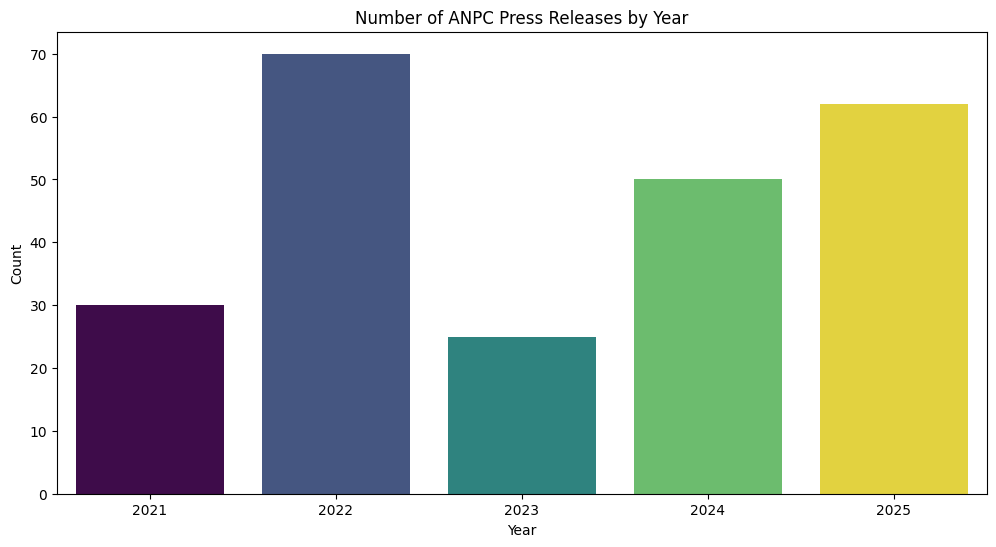

In [4]:
plt.figure(figsize=(12, 6))
sns.countplot(data=df, x='year', hue='year', palette='viridis', legend=False)
plt.title('Number of ANPC Press Releases by Year')
plt.ylabel('Count')
plt.xlabel('Year')
plt.show()

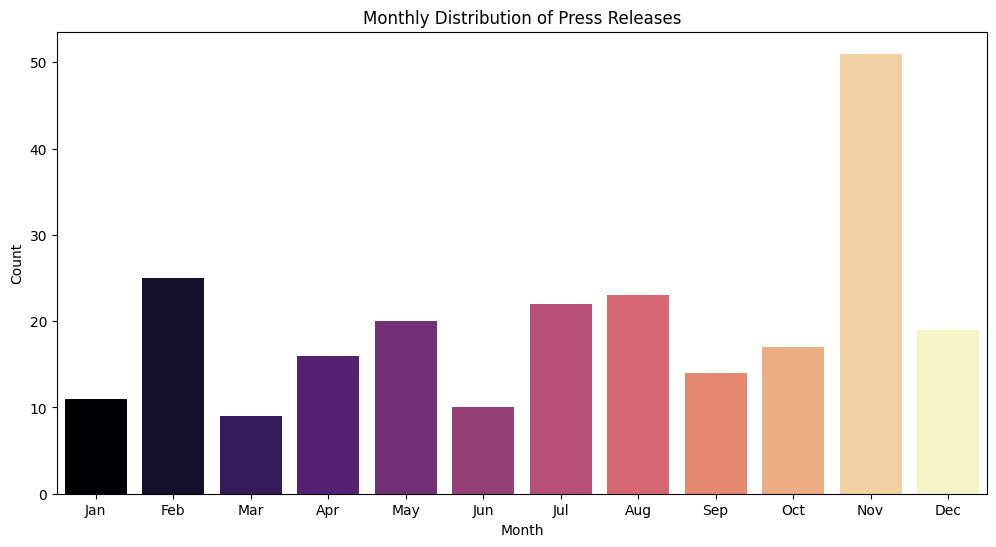

In [5]:
# Monthly distribution across all years
plt.figure(figsize=(12, 6))
sns.countplot(data=df, x='month', hue='month', palette='magma', legend=False)
plt.title('Monthly Distribution of Press Releases')
plt.ylabel('Count')
plt.xlabel('Month')
plt.xticks(ticks=range(12), labels=['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'])
plt.show()

## 4. Content Length Analysis

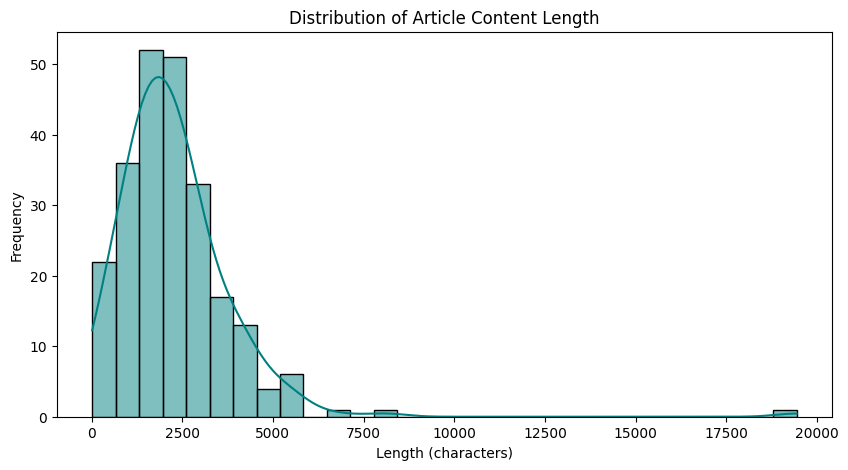

In [6]:
df['content_len'] = df['content_cleaned'].str.len()

plt.figure(figsize=(10, 5))
sns.histplot(df['content_len'], bins=30, kde=True, color='teal')
plt.title('Distribution of Article Content Length')
plt.xlabel('Length (characters)')
plt.ylabel('Frequency')
plt.show()

## 5. Top Tokens & N-grams (Raw Data)
Let's see the most frequent words in the cleaned (but not yet lemmatized) content.

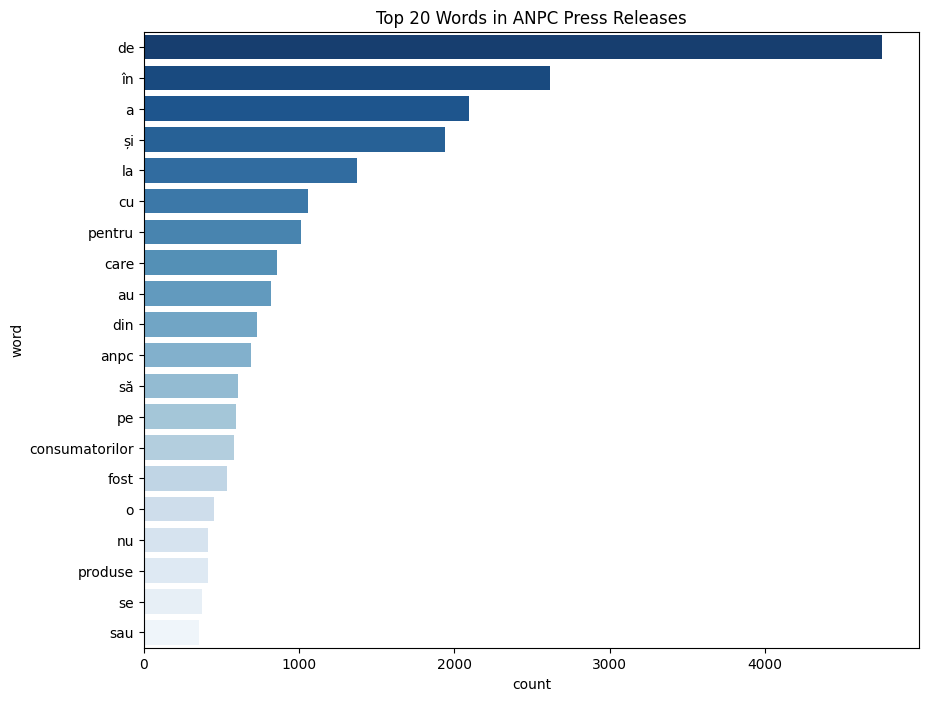

In [7]:
from collections import Counter
import re

def get_top_n_words(corpus, n=20):
    words = []
    for text in corpus:
        # Simple tokenization
        tokens = re.findall(r'\w+', text.lower())
        words.extend(tokens)
    return Counter(words).most_common(n)

top_words = get_top_n_words(df['content_cleaned'])
words_df = pd.DataFrame(top_words, columns=['word', 'count'])

plt.figure(figsize=(10, 8))
sns.barplot(data=words_df, y='word', x='count', palette='Blues_r', hue='word', legend=False)
plt.title('Top 20 Words in ANPC Press Releases')
plt.show()

## 5.1 Word Clouds
Visual summarizing the whole dataset.

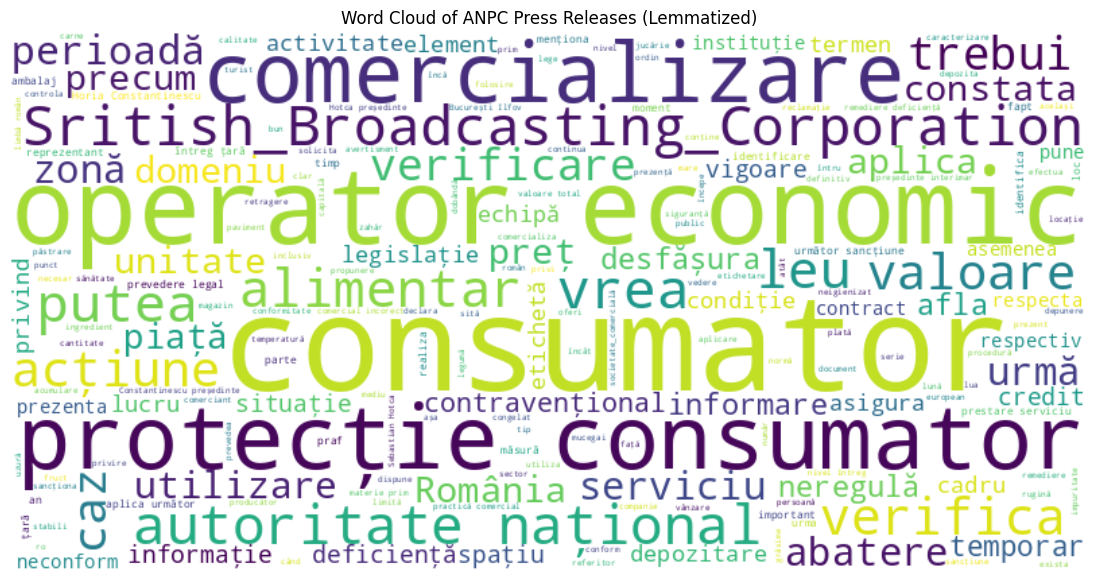

In [8]:
# Combine all lemmatized content for word cloud
all_text = " ".join(df['lemmatized_content'].dropna())

# Filter out custom stopwords manually for the wordcloud if needed
# Fix stopwords using the same logic as our models
refined_sw = TopicModeler()._fix_stopwords(custom_stopwords)

wc = WordCloud(
    width=800, 
    height=400, 
    background_color='white',
    colormap='viridis',
    stopwords=refined_sw
).generate(all_text)

plt.figure(figsize=(15, 7))
plt.imshow(wc, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud of ANPC Press Releases (Lemmatized)')
plt.show()

## 6. Calendar Plot
Visualizing the density of press releases across the calendar.

findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.


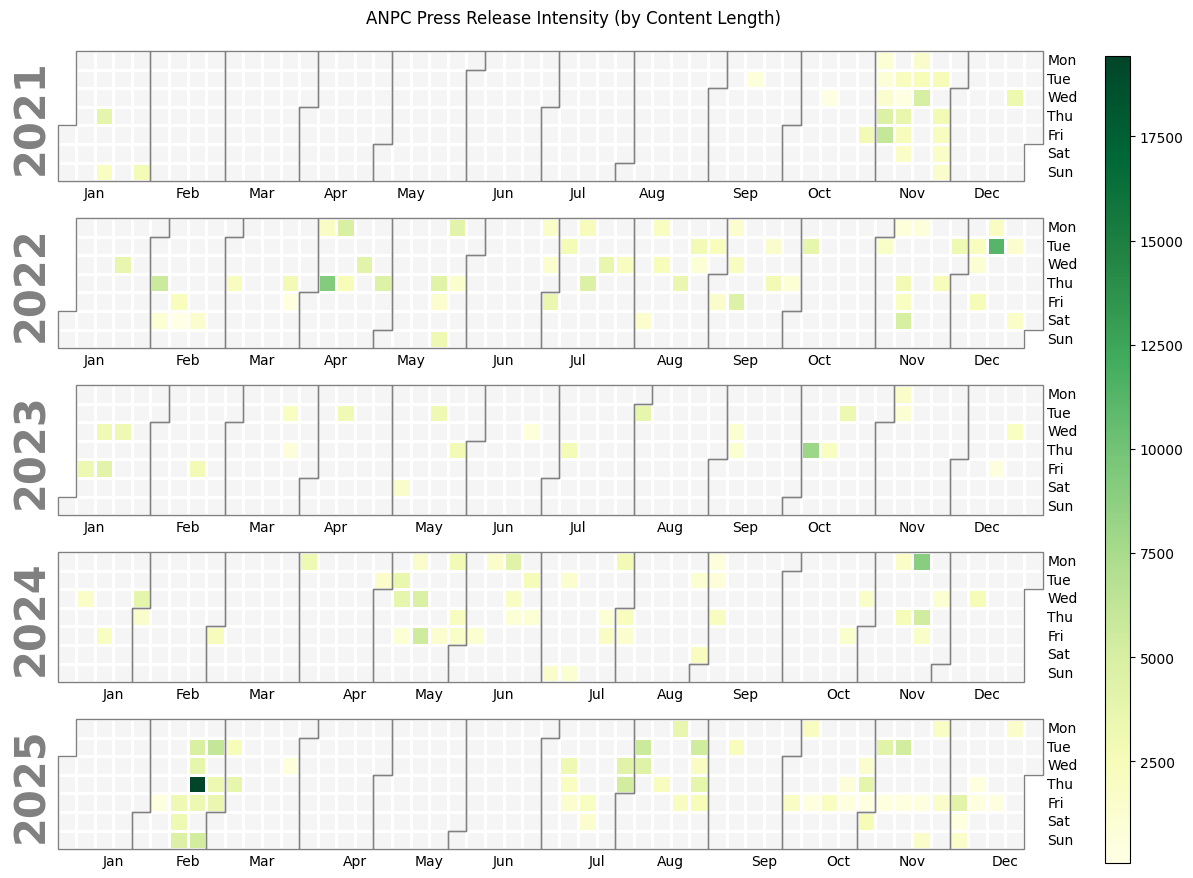

In [9]:
import calplot

# Set date as index for calplot
df_cal = df.set_index('date_dt')
# Filter for years with significant data
recent_df = df_cal[df_cal.index.year >= 2020]

calplot.calplot(recent_df['content_len'], 
                cmap='YlGn', 
                colorbar=True, 
                suptitle='ANPC Press Release Intensity (by Content Length)')
plt.show()

## 7. Date Interval Extraction
Extracting periods of control or activities from the text.

Found intervals in 41 articles.


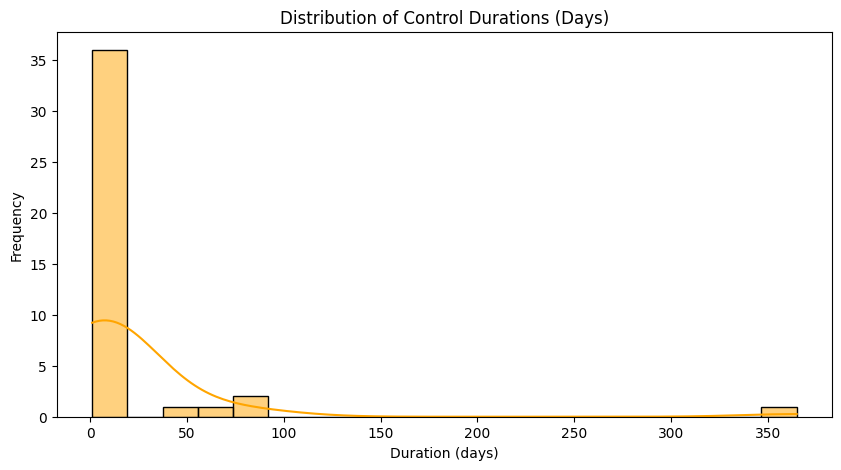

Average control duration: 21.4 days
Max duration: 365 days


,content_cleaned,intervals
196,Primele rezultate ale Comandamentului pentru E...,"[(2025-12-08 00:00:00, 2025-12-22 16:00:00)]"
195,Comandamentul pentru Energie creat de Autorita...,"[(2025-12-08 00:00:00, 2025-12-22 16:00:00)]"
166,Comandamentul pentru Energie - structură speci...,"[(2025-12-08 00:00:00, 2025-12-22 16:00:00)]"
233,Autoritatea Națională pentru Protecția Consuma...,"[(2025-12-08 00:00:00, 2025-12-22 16:30:00)]"
232,Autoritatea Națională pentru Protecția Consuma...,"[(2025-12-08 00:00:00, 2025-12-22 16:30:00)]"


In [10]:
from analysis.date_utils import extract_date_intervals

df['intervals'] = df['content_cleaned'].apply(extract_date_intervals)
df['n_intervals'] = df['intervals'].apply(len)

print(f"Found intervals in {df[df['n_intervals'] > 0].shape[0]} articles.")

# Insights from Intervals
if not df.empty:
    all_intervals = [item for sublist in df['intervals'] for item in sublist]
    if all_intervals:
        durations = [(end - start).days for start, end in all_intervals if end >= start]
        
        plt.figure(figsize=(10, 5))
        sns.histplot(durations, bins=20, kde=True, color='orange')
        plt.title('Distribution of Control Durations (Days)')
        plt.xlabel('Duration (days)')
        plt.ylabel('Frequency')
        plt.show()
        
        print(f"Average control duration: {sum(durations)/len(durations):.1f} days")
        print(f"Max duration: {max(durations)} days")

# Show examples
display(df[df['n_intervals'] > 0][['content_cleaned', 'intervals']].head())

## 8. Topic Modeling (LDA & NMF)
Using the lemmatized content for better topic discovery.

In [11]:
# TopicModeler and custom_stopwords are already defined at the top
modeler = TopicModeler(n_topics=5, stopwords=custom_stopwords)

# Use lemmatized content
docs = df['lemmatized_content'].tolist()

print("Fitting NMF model...")
modeler.fit_nmf(docs)
nmf_topics = modeler.get_topics('nmf', n_top_words=10)

print("\nNMF Topics (Refined):")
for idx, words in nmf_topics.items():
    print(f"Topic {idx}: {', '.join(words)}")

Fitting NMF model...

NMF Topics (Refined):
Topic 0: mega, alimentar, zonă, praf, comercializare, rest, image, strat, bucurești, consum
Topic 1: vrea, putea, credit, trebui, contract, caz, românia, persoană, situație, european
Topic 2: 2025, sancțiune, 12, protecție, următor, țară, întreg, aplica, 10, perioadă
Topic 3: comercializare, alimentar, leu, valoare, deficiență, 000, informare, grad, depunere, element
Topic 4: sritish_broadcasting_corporation, preț, ro, www, reducere, friday, black, sită, cluj, societate_comercială


### Topic Word Clouds
Visualizing top terms for each discovered topic.

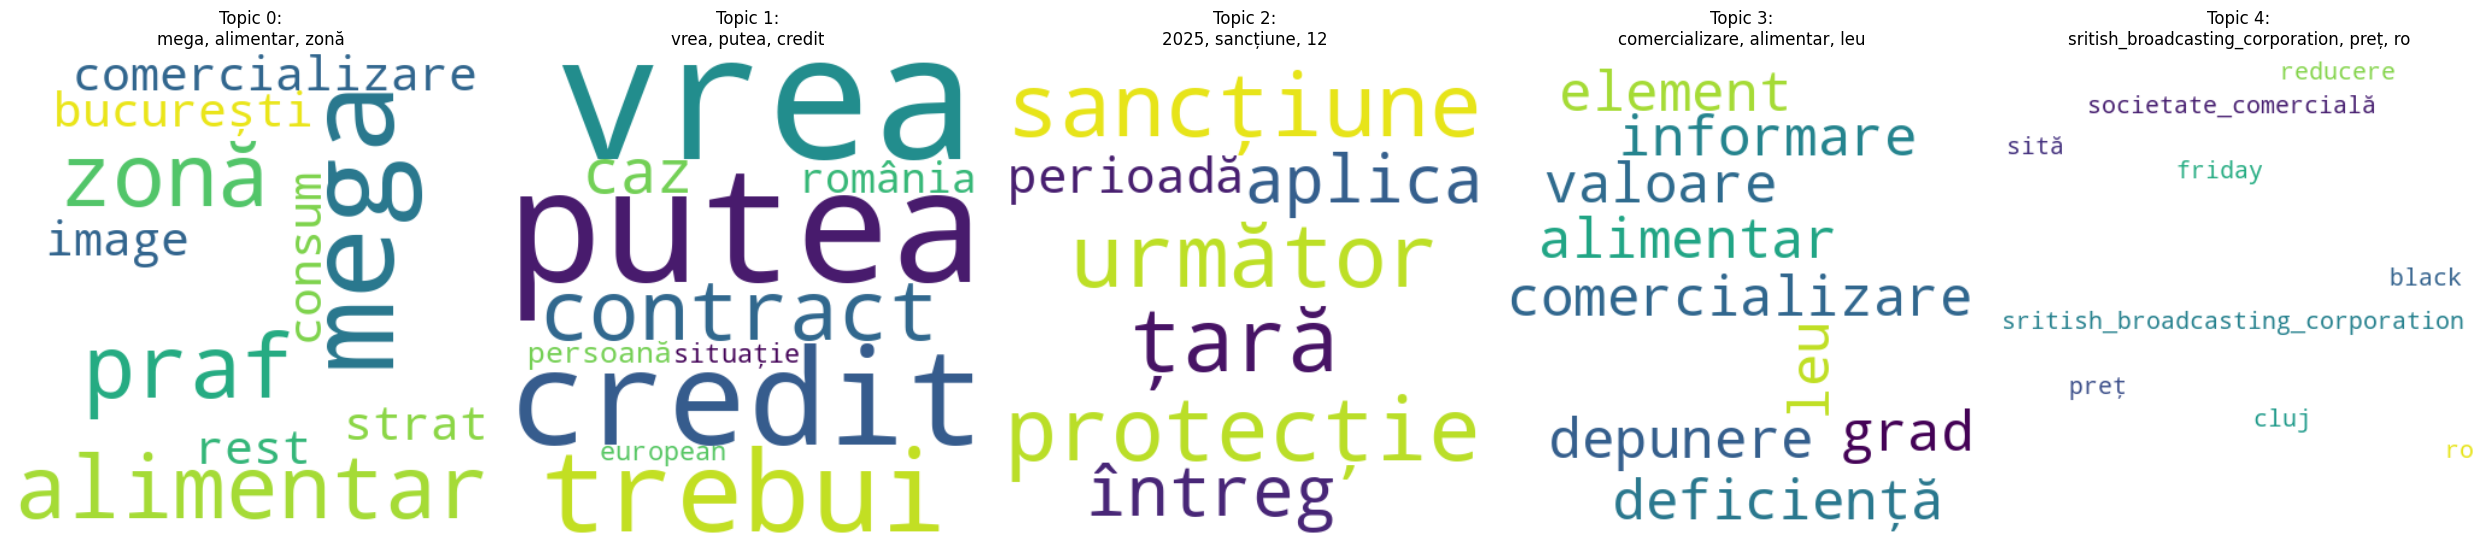

In [12]:
fig, axes = plt.subplots(1, 5, figsize=(25, 7))
for i in range(5):
    top_3 = ", ".join(nmf_topics[i][:3])
    topic_words = " ".join(nmf_topics[i])
    wc = WordCloud(width=400, height=400, background_color='white').generate(topic_words)
    axes[i].imshow(wc, interpolation='bilinear')
    axes[i].set_title(f'Topic {i}:\n{top_3}', fontsize=12)
    axes[i].axis('off')
plt.tight_layout()
plt.show()

## 9. Clustering
Grouping articles using K-Means and visualizing with PCA.

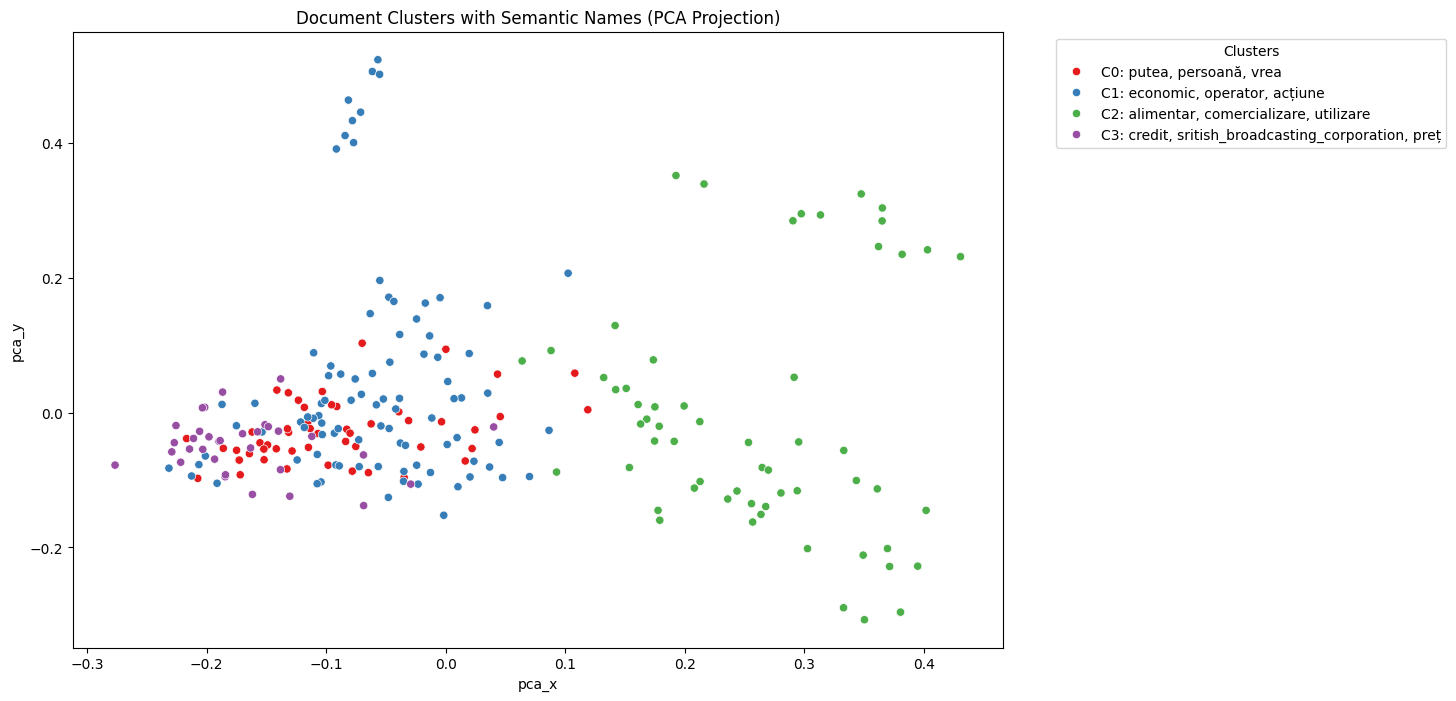

Cluster Descriptions:
Cluster 0: putea, persoană, vrea
Cluster 1: economic, operator, acțiune
Cluster 2: alimentar, comercializare, utilizare
Cluster 3: credit, sritish_broadcasting_corporation, preț


In [13]:
# DocumentClusher is already defined at the top
clusher = DocumentClusher(n_clusters=4, stopwords=custom_stopwords)
df['cluster'] = clusher.fit(docs)

# Get cluster names/descriptors
cluster_names = clusher.get_cluster_descriptors(n_words=3)
df['cluster_name'] = df['cluster'].apply(lambda x: f"C{x}: {cluster_names[x]}")
# Ensure categorical for better legend handling
df['cluster_name'] = pd.Categorical(df['cluster_name'], categories=[f"C{i}: {cluster_names[i]}" for i in range(4)])

coords = clusher.get_pca_coords(docs)
df['pca_x'] = coords[:, 0]
df['pca_y'] = coords[:, 1]

plt.figure(figsize=(12, 8))
sns.scatterplot(data=df.sort_values('cluster_name'), x='pca_x', y='pca_y', hue='cluster_name', palette='Set1')
plt.title('Document Clusters with Semantic Names (PCA Projection)')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', title="Clusters")
plt.show()

print("Cluster Descriptions:")
for i, name in enumerate(cluster_names):
    print(f"Cluster {i}: {name}")

## 10. BM25 Search Example
Searching for specific terms using BM25.

In [14]:
from analysis.topic_modeling import BM25Searcher

# Extract tokens as lemmas for BM25
tokenized_docs_lemmas = [[t['lemma'] for t in doc if t['pos'] != 'PUNCT'] for doc in df['content_tokens']]
searcher = BM25Searcher(tokenized_docs_lemmas)

query = ["produs", "expirat", "comisar"]
top_indices = searcher.search(query, n=3)

print(f"Top matches for query: {query}")
for idx in top_indices:
    print("-" * 20)
    print(f"Title: {df.iloc[idx]['title_cleaned']}")
    print(f"Snippet: {df.iloc[idx]['content_cleaned'][:200]}...")

Top matches for query: ['produs', 'expirat', 'comisar']
--------------------
Title: Grand Hotel Bucharest nu a reușit să remedieze neregulile. 100.000 lei amendă.
Snippet: Echipe ale Comisariatului pentru Protecția Consumatorilor Municipiul București (CPCMB) au realizat o acțiune de control, pe 19 mai 2022, la Compania Hotelieră Intercontinental România SA. În urma veri...
--------------------
Title: 48 de bătrâni hrăniți cu alimente expirate de luni de zile într-un centru din județul Bacău, în urma controlului ANPC
Snippet: În urma unui control efectuat de Autoritatea Națională pentru Protecția Consumatorilor (ANPC), au fost descoperite nereguli grave într-un centru de îngrijire din județul Bacău Asociatia Salvați Bătrân...
--------------------
Title: 7,7 milioane de lei
Snippet: În acest an, Autoritatea Națională pentru Protecția Consumatorilor (ANPC) desfășoară acțiuni de control în zonele de vacanță de iarnă, din România, respectiv în Bucovina, Brașov, Sibiu, Maramureș, Val...
